# 3-a: Bayesian Linear Regression

During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal**: Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.



## Summary

In this section, we worked with a Bayesian framework to understand uncertainty and the knowledge use in standard models. We saw through this work how the use of more data points per update influences the algorithm, how the data points in the dataset regroup the knowledge and how being further away from the dataset yields uncertainty, as well as how to handle it and reasonable methods of prediction making use of this knowledge. In this lab session, we studied methods to understand and handle uncertainty. We examined both linear and non-linear models, specifically utilizing polynomial and Gaussian basis functions. These functions were tested with various datasets, providing insights into their predictive variances and their suitability for different regions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

# Useful function: plot results
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range

    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot

    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])

    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")

    plt.legend()
    plt.show()

## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.

In [ ]:
# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
sigma = 0.2
nbpts=25
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, nbpts)
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=sigma)
dataset_linear['X_test'] = np.linspace(-10,10, 10*nbpts)
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=sigma)

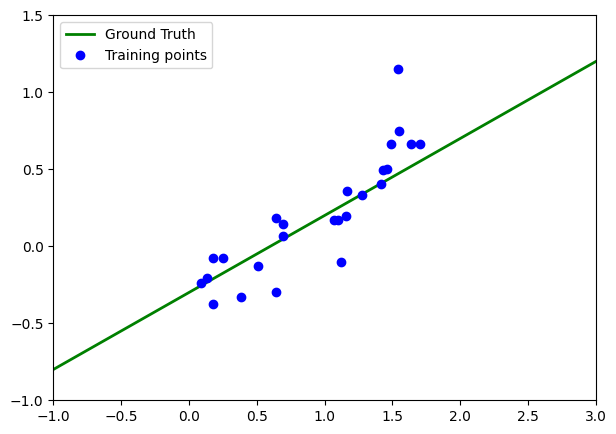

In [ ]:
# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [ ]:
# Hyperparameters
dataset_linear['ALPHA'] = 2.0
dataset_linear['BETA'] = 1/(2.0*sigma**2)

We will use the linear basis function:
    $\phi:x \rightarrow (1,x)$

Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_n
  \end{bmatrix}
$$

**Question 1.1: Code linear basis function**

In [ ]:
#TO DO: Define basis function

def phi_linear(x):
    """ Linear Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) linear features of x
    """
    phi = np.concatenate((np.ones(len(x)).reshape(-1, 1), x.T.reshape(-1, 1)), axis = 1)
    return phi


**Question 1.2: Recall closed form of the posterior distribution in linear case. Then, code and visualize posterior sampling. What can you observe?**

#### <b> Answer 1.2: </b>
We recall from the class that the closed for of the posterior distribution in the Linear case is:
\begin{equation}
\begin{split}
  p(w \lvert X,Y) &= \mathcal{N}(w \rvert \mu, \Sigma)\\
  \Sigma^{-1}_{f} &= \alpha \mathbb{I} + \beta \phi^T \phi\\
  \mu_{f} &= \beta \Sigma \phi^T Y
\end{split}
\end{equation}

From the visualization below, we can observe that:
Depending on the number of points used for estimation, the posterior distribution concentrates more (with the number of points increasing) around the weights (bias and scale) of our linear dataset (0.3,0.5), the true distribution. We can also see below that for the number of points being 10, we are closer to the truth than for n = 25, we see over confidence when the number of points given grows to large in front of the actual number of points (the distribution is highly concentrated around a point relatively far from the truth).

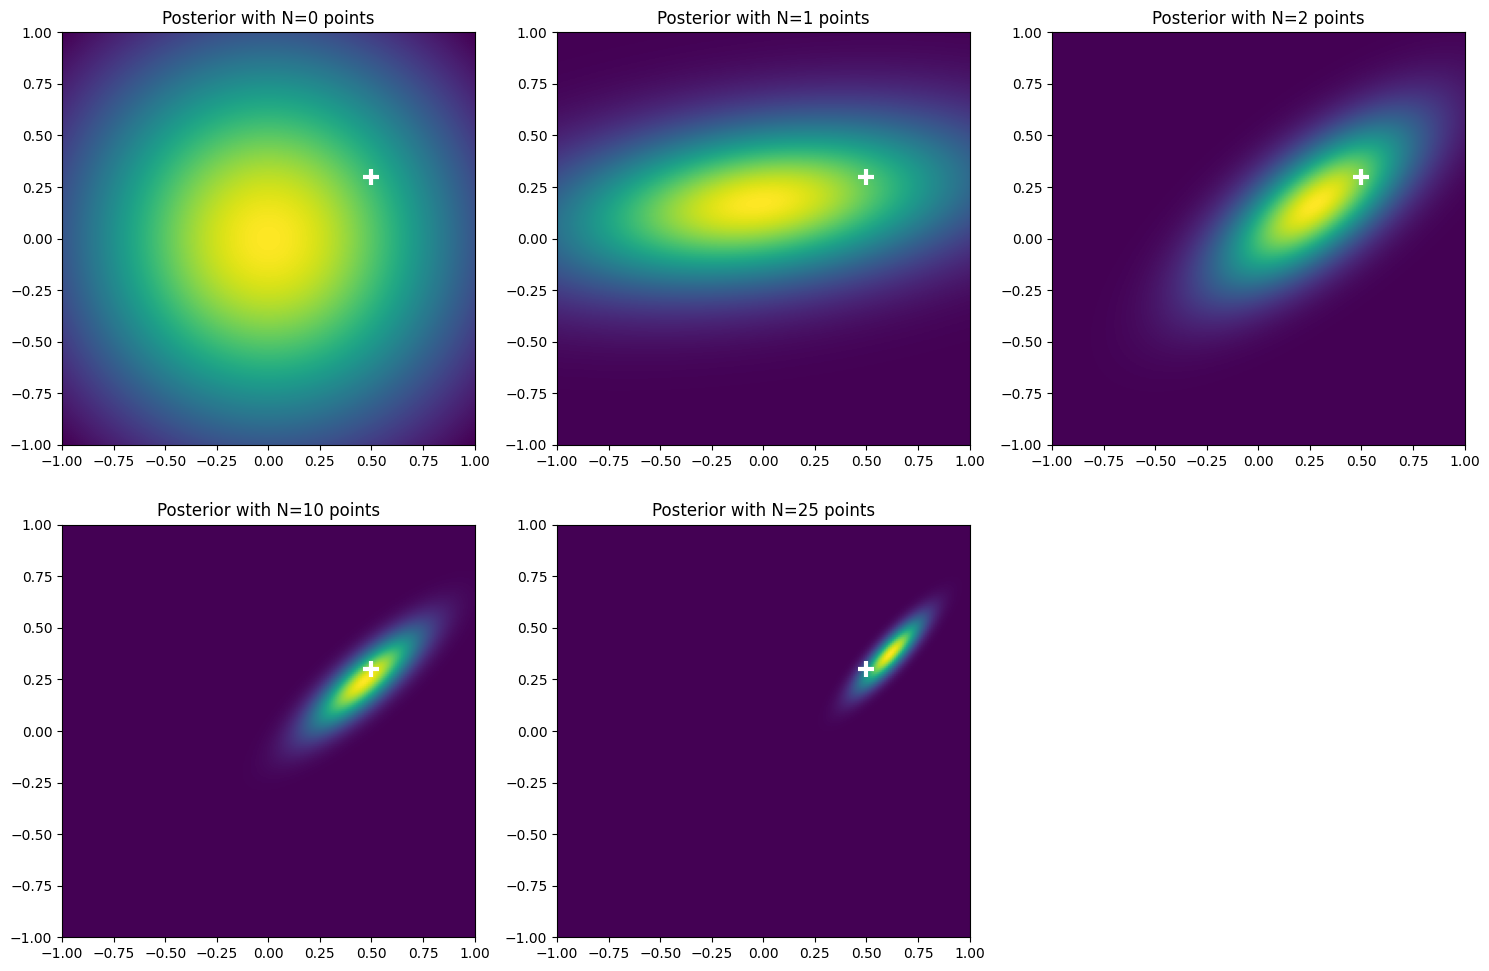

In [ ]:
#TO DO: Code and visualize posterior sampling by completing code below

plt.figure(figsize=(15,10))
for count,n in enumerate([0,1,2,10,len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]
    meshgrid = np.arange(-1, 1.01, 0.01)
    w = np.zeros((2,1))
    posterior = np.zeros((meshgrid.shape[0],meshgrid.shape[0]))

    # TO DO: code mu_N and sigma_N
    sigma_N = np.linalg.inv(dataset_linear["ALPHA"]*np.eye(2) + dataset_linear["BETA"]*np.dot(phi_linear(cur_data).T, phi_linear(cur_data)))
    mu_N = dataset_linear["BETA"]*np.dot(np.dot(sigma_N, phi_linear(cur_data).T), cur_lbl)

    # Compute values on meshgrid
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0,0] = meshgrid[i]
            w[1,0] = meshgrid[j]
            posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) )
    Z = 1.0 / ( np.sqrt(2*np.pi* np.linalg.det(sigma_N) ) )
    posterior[:,:] /= Z

    # Plot posterior with n points
    plt.subplot(231+count)
    plt.imshow(posterior, extent=[-1,1,-1,1])
    plt.plot(0.5,0.3, '+', markeredgecolor='white', markeredgewidth=3, markersize=12)
    plt.title('Posterior with N={} points'.format(n))
plt.tight_layout()
plt.show()

**Question 1.3: Recall and code closed form of the predictive distribution in linear case.**

#### <b> Answer 1.3: </b>
We recall from the class that the closed for of the posterior distribution in the Linear case is:
\begin{equation}
\begin{split}
  \mu_{pred}(x^*) &= \mu_{f}^T \phi(x^*)\\
  \sigma^2_{pred}(x^*) &= \frac{1}{\beta} + \phi(x^*)^T \Sigma \phi(x^*)
\end{split}
\end{equation}

(That we code up to a transpose for multi-variate purposes.)


In [ ]:
#TO DO: Code closed form solution according to the following requirements defined below

def closed_form(func, X_train, y_train, alpha, beta):
    """Define analytical solution to Bayesian Linear Regression, with respect to the basis function chosen, the
    training set (X_train, y_train) and the noise precision parameter beta and prior precision parameter alpha chosen.
    It should return a function outputing both mean and std of the predictive distribution at a point x*.

    Args:
      func: (function) the basis function used
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      alpha: (float) prior precision parameter
      beta: (float) noise precision parameter

    Returns:
      (function) prediction function, returning itself both mean and std
    """

    #TO DO
    def f_model(x) :
        sigma = np.linalg.inv(alpha*np.eye(func(x).shape[1]) + beta*np.dot(func(X_train).T, func(X_train)))
        mu = beta*np.dot(np.dot(sigma, func(X_train).T), y_train)

        sigma_pred = np.diag(((1/beta) + func(x)@sigma@func(x).T))
        mean_pred = func(x)@mu.T

        return((mean_pred, sigma_pred**(1/2)))


    return f_model

In [ ]:
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'],
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

**Question 1.4: Based on previously defined ``f_pred()``, predict on the test dataset. Then visualize results using ``plot_results()`` defined at the beginning of the notebook.**

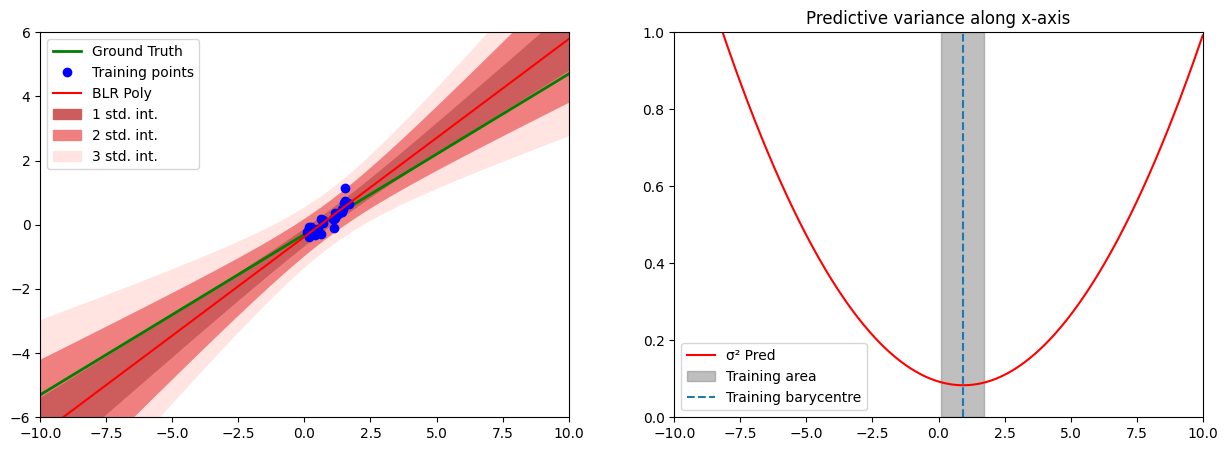

In [ ]:
# TO DO : predict on test dataset and visualize results
mu_pred, sigma_pred = f_pred(dataset_linear["X_test"])
plot_results(dataset_linear["X_train"], dataset_linear["y_train"], dataset_linear["X_test"], dataset_linear["y_test"],
             mu_pred, sigma_pred, -10, 10, -6, 6, 0, 1)
# You should use the following parameters for plot_results
# xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1

**Question 1.5: Analyse these results. Why predictive variance increases far from training distribution? Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

##### <b> Answer 1.5: </b>
The predictive increases far from the training points, because incertainty increases as we have less and less information, thus statistical inference yields less concentrated results, and leaves more room for unpredictable evolution of the process.
# TODO



**Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

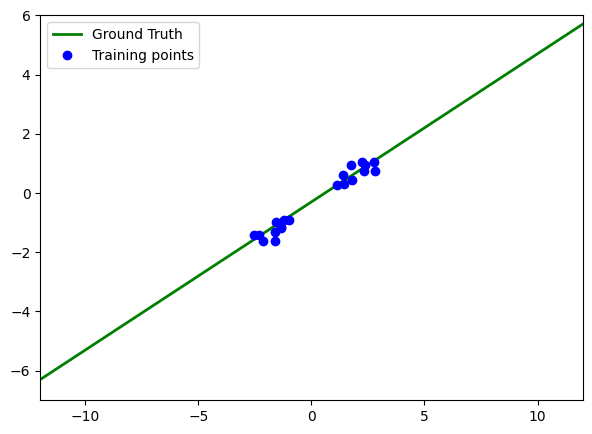

In [ ]:
# Create training and test points
sigma = 0.2
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=sigma)
dataset_hole['X_test'] = np.linspace(-12,12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0,sigma=sigma)
dataset_hole['ALPHA'] = 2.0
dataset_hole['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

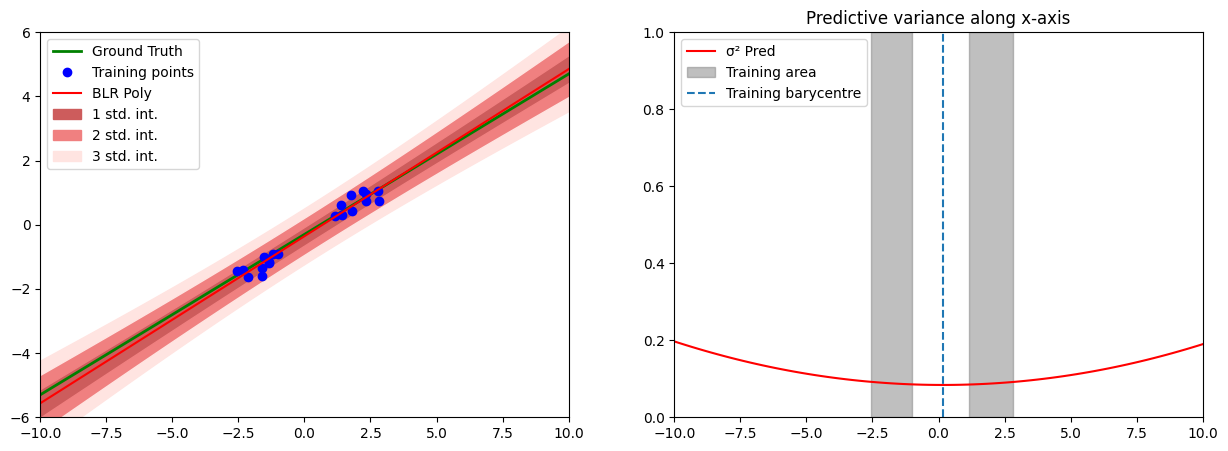

In [ ]:
# TO DO: Define f_pred, predict on test points and plot results

f_pred = closed_form(phi_linear, dataset_hole['X_train'], dataset_hole['y_train'],
                     dataset_hole['ALPHA'], dataset_hole['BETA'])

mu_pred, sigma_pred = f_pred(dataset_hole["X_test"])
plot_results(dataset_hole["X_train"], dataset_hole["y_train"], dataset_hole["X_test"], dataset_hole["y_test"],
             mu_pred, sigma_pred, -10, 10, -6, 6, 0, 1)

# You should use the following parameters for plot_results
# xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5

## Part II: Non Linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.

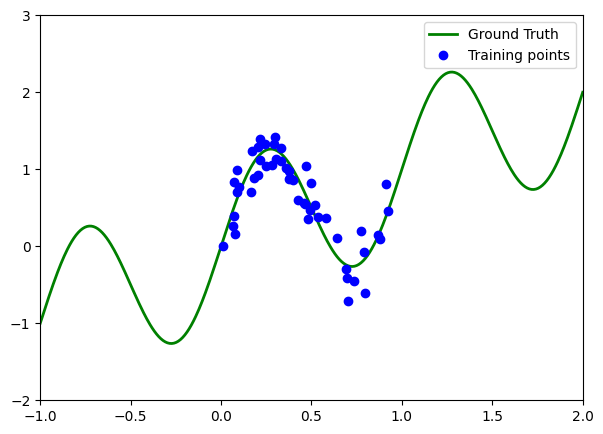

In [ ]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount,sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Create training and test points
sigma=0.2
nbpts=50
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpts)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1,sigma=sigma)
dataset_sinus['X_test'] = np.linspace(-1,2, 10*nbpts)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0,sigma=sigma)

dataset_sinus['ALPHA'] = 0.05
dataset_sinus['BETA'] = 1/(2.0*sigma**2)


# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-1, xmax = 2)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_{D-1})$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_n & x_n^2 &... &x_n^{D-1}
  \end{bmatrix}
$$

**Question 2.1: Code polynomial basis function**

In [ ]:
# Define basis function
def phi_polynomial(x, D = 10):
    """ Polynomial Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) polynomial features of x
    """
    return np.array([x**i for i in range(D)]).T

**Question 2.2 : Code and visualize results on sinusoidal dataset using polynomial basis functions. What can you say about the predictive variance?**

#### <b> Answer 2.2: </b>

Using the polynomial basis functions for a sinusoidal dataset, we see that the prediction tends to be less overly confident and quickly increases uncertainty - shown by the predictive variance - when we leave the dataset region. We understand that it is suited for a prediction for points in the region, as it will not try to imitate the trend outside of this region. Thus extremal points with a polynomial basis will be more prone to error. The prediction when the point gets further away from the region covered by the dataset boils down to randomly choosing a value.

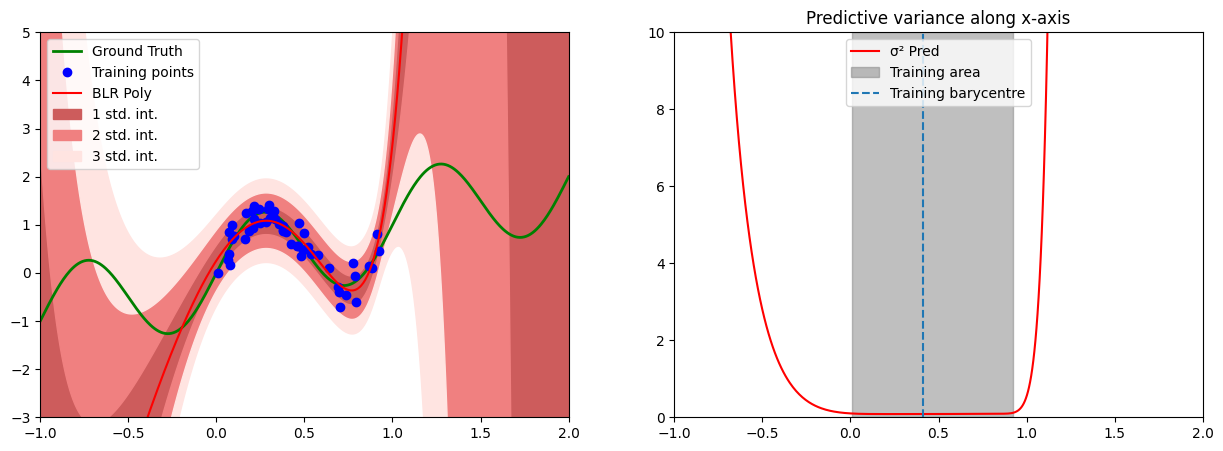

In [ ]:
# TO DO: Define f_pred, predict on test points and plot results
#TO DO: Code closed form solution according to the following requirements defined below

f_pred = closed_form(phi_polynomial, dataset_sinus["X_train"], dataset_sinus["y_train"],
                     dataset_sinus["ALPHA"], dataset_sinus["BETA"])

mu_pred, sigma_pred = f_pred(dataset_sinus["X_test"])
plot_results(dataset_sinus["X_train"], dataset_sinus["y_train"], dataset_sinus["X_test"], dataset_sinus["y_test"],
             mu_pred, sigma_pred, -1, 2, -3, 5, 0, 10)

# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10

### II.2 Gaussian basis functions

Now, let's consider gaussian basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_M)$$
where $\phi_j = \exp \Big ( -\frac{(x-\mu_j)^2}{2s^2} \Big )$ for $j \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    \phi_0(x_1) & \phi_1(x_1) &... &\phi_M(x_1) \\
    ... & ... & ... & ...\\
    \phi_0(x_n) & \phi_1(x_n) &... &\phi_M(x_n)
  \end{bmatrix}
$$

**Question 2.3: Code gaussian basis function**

In [ ]:
#TO DO: Define Gaussian basis function
MU_MIN = 0
MU_MAX = 1
M = 9

def phi_gaussian(x) :
    """ Gaussian Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) gaussian features of x
    """
    s = (MU_MAX-MU_MIN)/M
    return np.exp(-(x.reshape(-1, 1) - np.arange(MU_MIN, MU_MAX, s)) ** 2 / (2 * s * s))

In [ ]:
x = np.array([1,2,3])
print(phi_gaussian(x))

[[2.57675711e-018 1.26641655e-014 2.28973485e-011 1.52299797e-008
  3.72665317e-006 3.35462628e-004 1.11089965e-002 1.35335283e-001
  6.06530660e-001]
 [4.40853133e-071 1.75568810e-063 2.57220937e-056 1.38634329e-049
  2.74878501e-043 2.00500878e-037 5.38018616e-032 5.31109225e-027
  1.92874985e-022]
 [5.00796571e-159 1.61608841e-147 1.91855567e-136 8.37894253e-126
  1.34619985e-115 7.95674389e-106 1.73008221e-096 1.38389653e-087
  4.07235863e-079]]


**Question 2.4 : Code and visualize results on sinusoidal dataset using Gaussian basis functions. What can you say this time about the predictive variance?**

#### <b> Answer 2.4: </b>

We see that using a gaussian basis for sinusoidal function, leads to over-confident estimator in regions not covered by the dataset, but a stable predictive variance overall. We see that the main variations in the variance happen in the region covered and on its borders, with its peaks at the borders. Once again this is better suited for estimation in areas somehow covered by the dataset. The difference here is that for a point further away from the dataset, this method boils down to estimating using the mean over the dataset instead of highly unstable points as for the polynomial method.

The pro of this method over the polynomial one is stability outside of the dataset, but the con is over confidence outside of the dataset (the 3 standard deviation region does not cover the ground truth anymore).

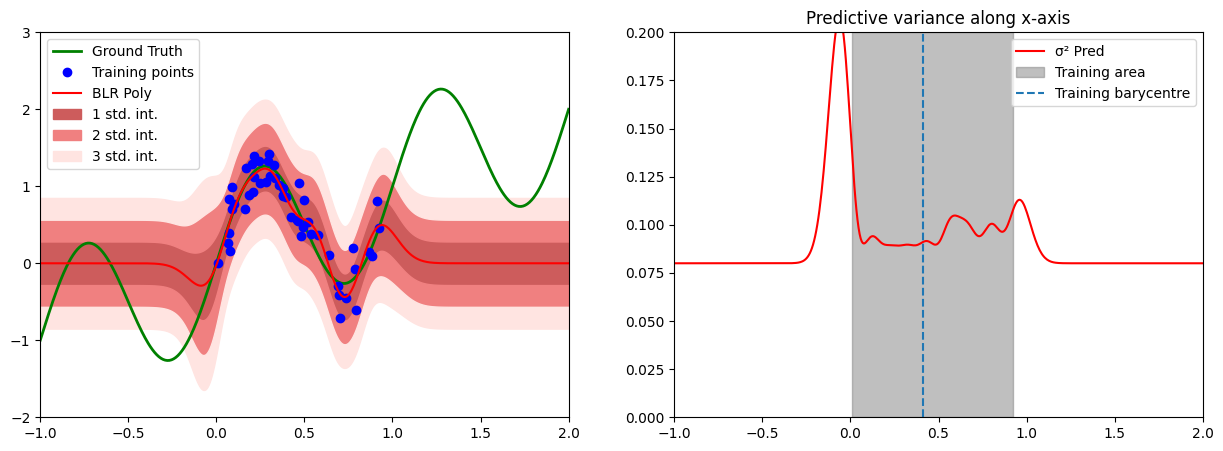

In [ ]:
# TO DO: Define f_pred, predict on test points and plot results

f_pred = closed_form(phi_gaussian, dataset_sinus["X_train"], dataset_sinus["y_train"],
                     dataset_sinus["ALPHA"], dataset_sinus["BETA"])

mu_pred, sigma_pred = f_pred(dataset_sinus["X_test"])
plot_results(dataset_sinus["X_train"], dataset_sinus["y_train"], dataset_sinus["X_test"], dataset_sinus["y_test"],
             mu_pred, sigma_pred, -1, 2, -2, 3, 0, 0.2)

# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2

**Question 2.5: Explain why in regions far from training distribution, the predictive variance converges to this value when using localized basis functions such as Gaussians.**

#### <b> Answer 2.5: </b>

Far from the training points, the epistemic uncertainty converges to 0 for localized basis functions such as Gaussian functions. This comes from the fast decay of such localized basis (the exponential decay for Gaussian basis), further away from the dataset, $x^*-\mu_j$ will increase for every $j$ thus the value of the exponential decaying toward 0, and the variance being:
\begin{equation}
  \sigma^2 = \frac{1}{\beta} + \phi(x^*)^T \Sigma \phi(x^*)
\end{equation}
It converges towards $\frac{1}{\beta} = 2 \times (0.2)^2 = 0.08$.